# IMAGE CAPTIONING AND SEGMENTATION

## Introduction

This project demonstrates the combined use of **image captioning** and **image segmentation** using modern deep learning models.

- **Image Captioning**: Generating descriptive text for an image using a pre-trained model like BLIP.
- **Image Segmentation**: Identifying and highlighting specific regions or objects within an image using models like SAM (Segment Anything Model).

These tasks help machines visually understand and describe the world, and have practical applications in autonomous systems, medical imaging, accessibility tools, and more.

In [1]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-3ko_67is
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-3ko_67is
  Resolved https://github.com/huggingface/transformers.git to commit 34133d0a790787739bfc9a42603985de3728ede4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.54.0.dev0-py3-none-any.whl size=11913458 sha256=c3e17cc592fee0bef1243ec3dc7a193b1e67ade60697640d50f83404229296e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-5jr7cmlb/wheels/32/4b/78/f195c684dd3a9ed21f3b39fe8f85b48df7918581b6437be143
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2
  Cloning https://github.co


## What is BLIP?

**BLIP (Bootstrapped Language Image Pretraining)** is a vision-language model designed to generate captions from images. It combines computer vision (image understanding) with natural language processing (text generation) using a Transformer-based architecture.

In this notebook, we use the BLIP model from HuggingFace to automatically generate captions for uploaded images.



## What is SAM (Segment Anything Model)?

**SAM (Segment Anything Model)** by Meta AI is a Transformer-based model that can segment any object in any image, given just a prompt like a bounding box, point, or mask.

It is useful for identifying and extracting specific regions or objects from an image, making it ideal for object-level captioning.


## Load image

Either using URL or from local device.

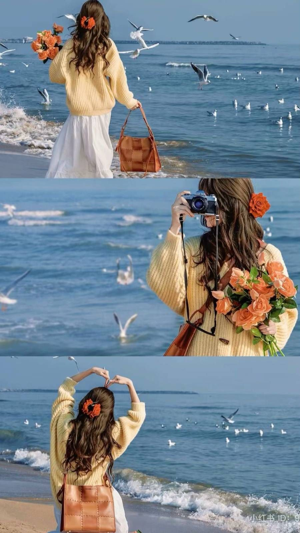

In [11]:
import requests
from PIL import Image

# from Segment Anything demo
# url = 'https://segment-anything.com/assets/gallery/GettyImages-1207721867.jpg'
url = 'https://i.pinimg.com/1200x/95/e8/e5/95e8e567487a3eb143a18505900fc8fa.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

# # from local device
# img_path = './demo.jpg'
# image = Image.open(img_path).convert('RGB')

width, height = image.size
display(image.resize((width // 3, height // 3)))

## Load segmenter

Before using the Segment Anything Model(SAM), let's download the checkpoint of SAM and save it to the current directory.

In [3]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-07-20 13:20:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.236.98, 18.239.236.78, 18.239.236.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.236.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   171MB/s    in 17s     

2025-07-20 13:20:17 (148 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



Next, we leverage the downloaded checkpoint to initialize the SAM, where 'vit_h' is chosen as the backbone in our example.

It is highly recommended to run SAM in GPU! It will make generation faster.

In [12]:
import torch
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if 'cuda' in device else torch.float32
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'

# SAM initialization
model = sam_model_registry[model_type](checkpoint = checkpoint)
model.to(device)
predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model)
predictor.set_image(np.array(image)) # load the image to predictor

model

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

SAM produces high quality object masks from input prompts such as points or boxes, and even masks. Here, we take click prompt (i.e., points) as and example.

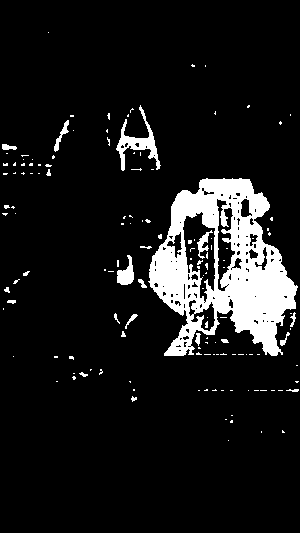

In [13]:
input_point = [[1800, 950]] # A Nx2 array of point prompts to the model. Each point is in (X,Y) in pixels.
input_label = [1]           # A length N array of labels for the point prompts. 1 indicates a foreground point and 0 indicates a background point.
input_point = np.array(input_point)
input_label = np.array(input_label)
masks, scores, logits = predictor.predict(point_coords = input_point, point_labels = input_label)
masks = masks[0, ...]

display(Image.fromarray(masks).resize(((width // 3, height // 3))))

## Crop the image

we next crop the masked objects from the origin image generated by SAM.

To crop the image, we should choose whether to remain the background of the image firstly!

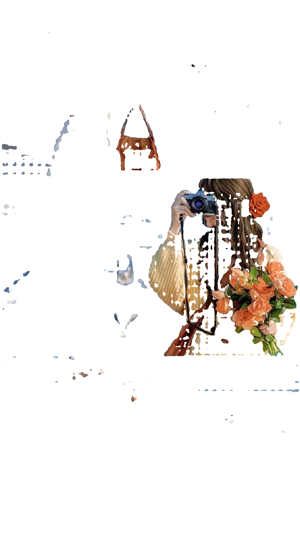

In [14]:
crop_mode = "wo_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

if crop_mode == "wo_bg":
    masked_image = image * masks[:,:,np.newaxis] + (1 - masks[:,:,np.newaxis]) * 255
    masked_image = np.uint8(masked_image)
else:
    masked_image = np.array(image)
masked_image = Image.fromarray(masked_image)

display(masked_image.resize((width // 3, height // 3)))

Then, we use a regular box to cut the objects from the image as an example.

Note that the masks is a 2D matrix where 1 indicates a foreground point and 0 indicates a background point. To obtain the regular box containing masked objects, we reshape the 2D matrix to an vector, and the first 1 (A) appearing in this vector must be the point on the upper boundary of regular box. We can prove this conclusion through proof to the contrary. We suppose A is not the upper boundary of regular box which means that there is a higher foreground point (B) in the masks. When we reshape masks to an vector, B must appear before A, which is contradictory with suppose.

Once we obtain the index of A in the vector, we divide it by the number of the rows to get the position of boundary. Similarly, we can get the lower, left and right boundary too!

0.00375 0.06 0.56 0.826875


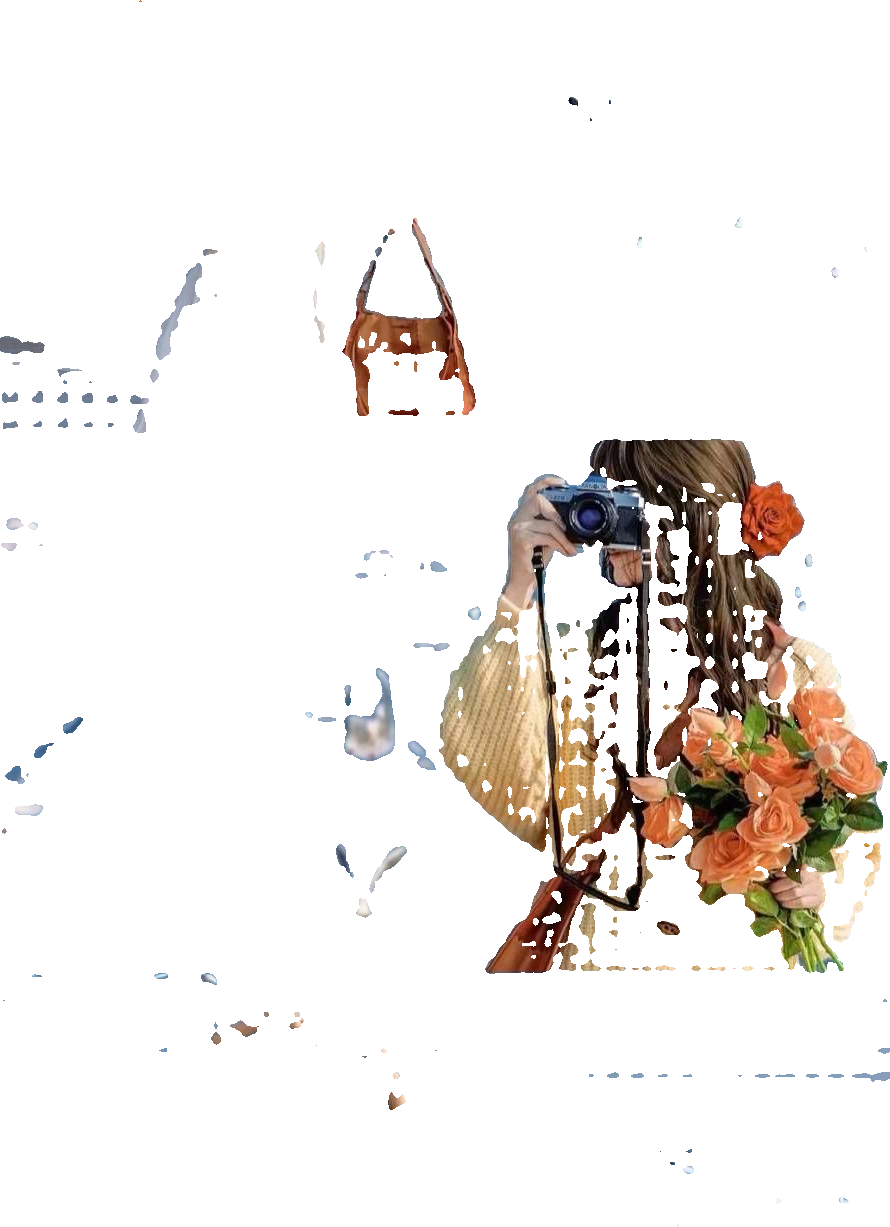

In [15]:
def boundary(inputs):

    col = inputs.shape[1]
    inputs = inputs.reshape(-1)
    lens = len(inputs)
    start = np.argmax(inputs)
    end = lens - 1 - np.argmax(np.flip(inputs))
    top = start // col
    bottom = end // col

    return top, bottom

def seg_to_box(seg_mask, size):

    top, bottom = boundary(seg_mask)
    left, right = boundary(seg_mask.T)
    left, top, right, bottom = left / size, top / size, right / size, bottom / size # we normalize the size of boundary to 0 ~ 1

    return [left, top, right, bottom]

size = max(masks.shape[0], masks.shape[1])
left, top, right, bottom = seg_to_box(masks, size) # calculating the position of the top-left and bottom-right corners in the image
print(left, top, right, bottom)

image_crop = masked_image.crop((left * size, top * size, right * size, bottom * size)) # crop the image
display(image_crop)

## Load captioning model

Here, we leverage BLIP2 as the captioning model. In order to accelarate the inference speed, let us start by install accelerate and bitsandbytes library to enable model acceleration and int8 quantization algorithm.

In [8]:
!pip install accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Let's load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI. We choose 2.7-billion-parameters BLIP2 as an example, for more scales, refer to: https://huggingface.co/spaces/Salesforce/BLIP2.

In [9]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
captioning_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map = "sequential", load_in_8bit = True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Now, everything is ready, let's caption now! Defaultly, BLIP2 will start generating caption related to the image from the BOS token.

In [16]:
inputs = processor(image_crop, return_tensors = "pt").to(device, torch_dtype)
out = captioning_model.generate(**inputs, max_new_tokens = 50)
captions = processor.decode(out[0], skip_special_tokens = True).strip()

captions

'a woman taking a picture of flowers with a camera'